In [1]:
from typing import Any
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
import numpy as np

import hodel


class Triplet(hodel.EnergyModel):
    """3 node spring where Theta is [K_1, K_2]"""

    def __init__(self, xf0, xb0):
        x0 = xb0[0]
        x1, x2 = xf0
        self.l_k = jnp.array([x1 - x0, x2 - x1])

    @staticmethod
    def get_strain(x0, x1, x2, l_k) -> jax.Array:
        return jnp.array([x1 - x0, x2 - x1]) / l_k
    
    def get_K(self, del_strain: jax.Array, Theta: jax.Array) -> jax.Array:
        return jnp.diag(jnp.abs(Theta))

    def get_energy(
        self,
        xf: jax.Array,
        xb: jax.Array = jnp.array([]),
        Theta: jax.Array = jnp.array([]),
        aux=None,
    ) -> jax.Array:
        # xb = [x0], xf = [x1, x2]
        x0 = xb[0]
        x1, x2 = xf
        del_strain = self.get_strain(x0, x1, x2, self.l_k) - 1.0
        return 0.5 * del_strain @ self.get_K(del_strain, Theta) @ del_strain

class LinearForce(hodel.ExternalForce):
    """ Linear force with offset """
    def __init__(self, f: jax.Array, c: jax.Array) -> None:
        self.f = f  # shape matches xf
        self.c = c

    def get_grad_energy(self, lambda_: jax.Array, aux: Any = None) -> jax.Array:
        return lambda_* self.f + self.c


def fixed_0(lambda_: jax.Array, _ = None) -> jax.Array:
    return jnp.array([0.0])

# Setup
xf0 = jnp.array([1.0, 2.0])
energy = Triplet(xf0, fixed_0(jnp.array([0.0])))
force = LinearForce(jnp.array([0.0, 10.0]), jnp.array([9.81, 0.0]))
sim = hodel.HODEL(energy, [force], fixed_0)

key = jax.random.PRNGKey(0)
Theta_star = jnp.array([5.0, 2.0])
lambdas = jnp.linspace(0, 1, 10)

print("λ=0: ", sim.solve(jnp.array([0.0]), xf0, Theta_star))
print("λ=1: ", sim.solve(jnp.array([1.0]), xf0, Theta_star))

λ=0:  [2.9620001 3.9620001]
λ=1:  [ 4.9620004 10.962    ]


In [2]:
xf_stars = sim.sim(lambdas, xf0, Theta_star)
Theta0 = jax.random.uniform(key, [2], minval=1e-1, maxval=1e1)
lr = 1e-1
n_epochs = 100

final_Theta, L = sim.learn(
    lambdas, xf0, xf_stars, Theta0, optim=optax.adam(lr), n_epochs=n_epochs
)

print("True Theta:", Theta_star)
print("Theta0:", Theta0)
print("Final Theta:", final_Theta)

True Theta: [5. 2.]
Theta0: [9.481903 9.787941]
Final Theta: [5.080398  1.9809085]


In [3]:
import flax.linen as nn


class KSTriplet(Triplet):
    def get_K(self, del_strain, Theta):
        # Theta = [K0_1, alpha_1, K0_2, alpha_2]
        K0_1, alpha_1, K0_2, alpha_2 = Theta
        K1 = K0_1 * jnp.exp(alpha_1 * del_strain[0])
        K2 = K0_2 * jnp.exp(alpha_2 * del_strain[1])
        return jnp.diag(jnp.array([K1, K2]))


Theta_star = jnp.array([5.0, 0.6, 2.0, 0.6])
ks_energy = KSTriplet(xf0, fixed_0(jnp.array([0.0])))
ks_sim = hodel.HODEL(ks_energy, [force], fixed_0)

class KNet(nn.Module):
    """Simple 2 x 2 PSD module"""

    hidden_size: int

    @nn.compact
    def __call__(self, del_strain):
        x = nn.softplus(
            nn.Dense(
                self.hidden_size,
            )(del_strain)
        )
        x = nn.Dense(
            2,
            kernel_init=nn.initializers.zeros,
            bias_init=nn.initializers.constant(5.0),
        )(x)
        a, b = x
        a = jax.nn.softplus(a)
        b = jax.nn.softplus(b)
        return jnp.array([[a, 0.0], [0.0, b]])

    @nn.compact
    def psd(self, del_strain):
        x = nn.tanh(nn.Dense(self.hidden_size)(del_strain))
        x = nn.Dense(3)(x)
        a, b, c = x
        a = jax.nn.softplus(a)
        c = jax.nn.softplus(c)
        L = jnp.array([[a, 0.0], [b, c]])
        return L @ L.T


class NNTriplet(Triplet):
    """3 node spring where Theta is a neural network."""

    def __init__(self, xf0, xb0, model):
        super().__init__(xf0, xb0)
        self.model = model

    def get_K(self, del_strain: jax.Array, Theta: Any) -> jax.Array:
        return model.apply(Theta, del_strain)  # type: ignore


# TODO: Figure out how to make this more seamless
model = KNet(10)
params = model.init(key, jnp.zeros(2))
nn_energy = NNTriplet(xf0, fixed_0(jnp.array([0.0])), model)
nn_sim = hodel.HODEL(nn_energy, [force], fixed_0)

print(
    "λ=0: ",
    nn_sim.solve(jnp.array([0.0]), xf0, params),
    ks_sim.solve(jnp.array([0.0]), xf0, Theta_star),
)
print(
    "λ=1: ",
    nn_sim.solve(jnp.array([1.0]), xf0, params),
    ks_sim.solve(jnp.array([1.0]), xf0, Theta_star),
)

λ=0:  [2.9593685 3.9593685] [1.9001582 2.9001582]
λ=1:  [4.956686  7.9540033] [2.3032076 4.757688 ]


truth:  [[1.9001582 2.9001582]
 [1.9562654 3.3489454]
 [2.008644  3.645342 ]
 [2.0577948 3.8765035]
 [2.1041214 4.0695925]
 [2.1479535 4.237124 ]
 [2.1895652 4.386041 ]
 [2.2291863 4.5206556]
 [2.2670114 4.6438565]
 [2.3032076 4.757688 ]]
nn:  [[1.9057918 2.8870397]
 [1.9607517 3.377485 ]
 [2.0052567 3.6455514]
 [2.048703  3.858273 ]
 [2.0923824 4.0436635]
 [2.1365898 4.2124686]
 [2.1813521 4.370075 ]
 [2.226608  4.5196047]
 [2.272268  4.6630397]
 [2.3182364 4.801719 ]]


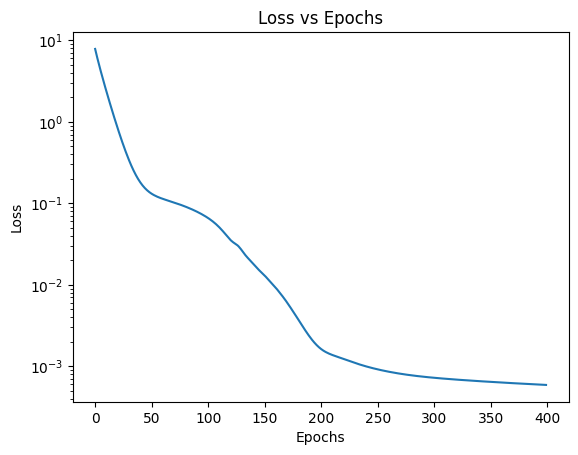

In [6]:
xf_stars = ks_sim.sim(lambdas, xf0, Theta_star)

lr = 1e-2
n_epochs = 400
final_params, L = nn_sim.learn(
    lambdas, xf0, xf_stars, params, optim=optax.adam(lr), n_epochs=n_epochs
)

print("truth: ", xf_stars)
print("nn: ", nn_sim.sim(lambdas, xf0, final_params))

plt.plot(L)
plt.yscale("log")
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

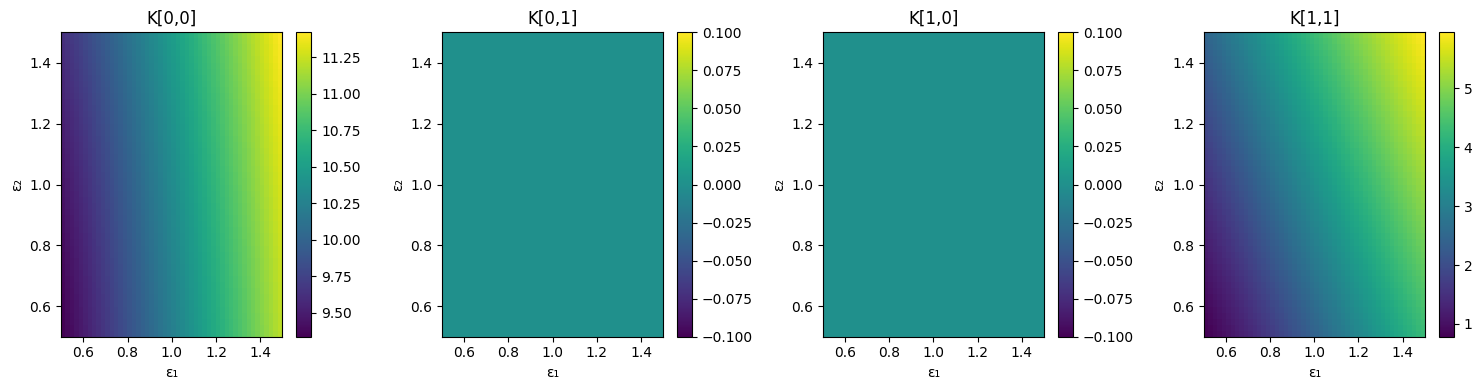

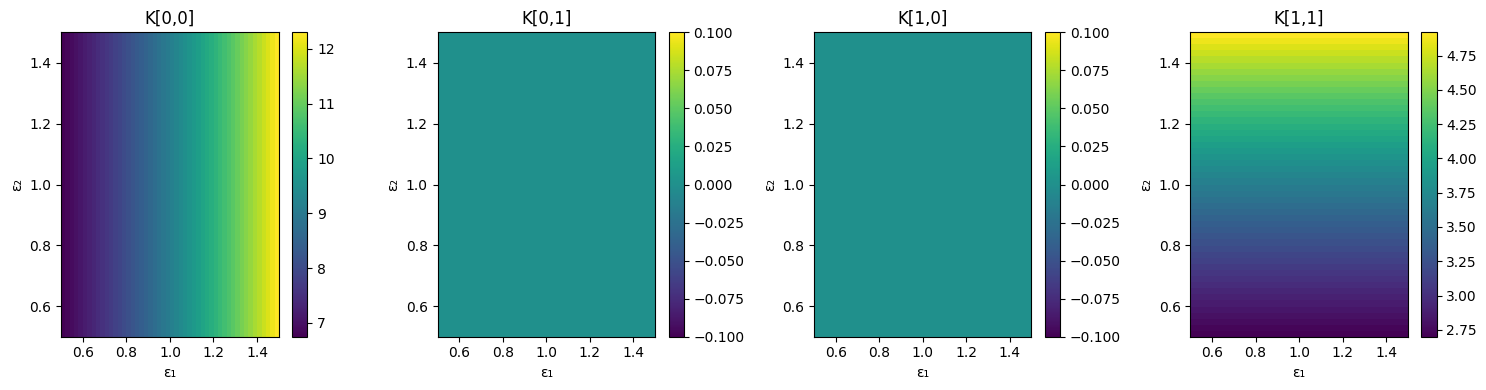

In [7]:
# del_strain is a [esp1, esp2] vector.
eps1 = jnp.linspace(0.5, 1.5, 50)
eps2 = jnp.linspace(0.5, 1.5, 50)
E1, E2 = jnp.meshgrid(eps1, eps2)
del_strains = jnp.stack([E1.ravel(), E2.ravel()], axis=-1)

# Generate map of Ks
nn_K = jax.vmap(lambda s: nn_energy.get_K(s, final_params))(del_strains)
ks_K = jax.vmap(lambda s: ks_energy.get_K(s, Theta_star))(del_strains)

def visualize_K(K, title = "K vs Strains"):
    K11 = K[:, 0, 0].reshape(E1.shape)
    K12 = K[:, 0, 1].reshape(E1.shape)
    K21 = K[:, 1, 0].reshape(E1.shape)
    K22 = K[:, 1, 1].reshape(E1.shape)

    fig, axs = plt.subplots(1, 4, figsize=(15, 4))
    for ax, K, title in zip(
        axs, [K11, K12, K21, K22], ["K[0,0]", "K[0,1]", "K[1,0]", "K[1,1]"]
    ):
        im = ax.imshow(np.asarray(K), extent=(eps1.min(), eps1.max(), eps2.min(), eps2.max()),
                    origin='lower', cmap='viridis', aspect='auto')
        ax.set_xlabel("ε₁")
        ax.set_ylabel("ε₂")
        ax.set_title(title)
        fig.colorbar(im, ax=ax)
    plt.title(title)
    plt.tight_layout()
    plt.show()

visualize_K(nn_K)
visualize_K(ks_K)